Estratégia de momento baseada 

[Tobias J. Moskowitza, Yao Hua Ooi and Lasse Heje Pedersen, Time Series Momentum. Journal of Financial Economics, 104, 2. 2012, 228-250.](http://docs.lhpedersen.com/TimeSeriesMomentum.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import time

In [2]:
def import_data(csv): 
    def extrair_caracteres(s):
        import re
        pattern = re.compile(r"([^_]+)_")
    
        match = pattern.match(s)
        if match:
                return match.group(1)
        else:
             return None
    
    df = pd.read_csv(csv, sep=';' , decimal='.')
    df.index = pd.to_datetime(df['datetime'])#, format = "%y-%m-%d")
    df = df.drop('datetime', axis=1)
    
    close_columns    = []
    high_columns     = []
    low_columns      = []
    open_columns     = []
    volume_columns   = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    dicH = {s:extrair_caracteres(s) for s in high_columns}
    dicL = {s:extrair_caracteres(s) for s in low_columns}
    dicO = {s:extrair_caracteres(s) for s in open_columns}
    dicC = {s:extrair_caracteres(s) for s in close_columns}
    dicV = {s:extrair_caracteres(s) for s in volume_columns}
    
    close_df    = df[close_columns].rename(columns=dicC)
    high_df     = df[high_columns].rename(columns=dicH)
    low_df      = df[low_columns].rename(columns=dicL)
    open_df     = df[open_columns].rename(columns=dicO)
    volume_df   = df[volume_columns].rename(columns=dicV)
 
    return [close_df, high_df, low_df, open_df, volume_df]

In [3]:
close_df, high_df, low_df, open_df, volume_df = import_data("data/tvohlc.csv" )
volume_df.tail(2)


,RRRP3,TTEN3,ABCB4,AERI3,AESB3,AALR3,ALOS3,ALPA4,ALUP11,AMBP3,...,TRIS3,TUPY3,UNIP6,USIM5,VLID3,VIVA3,VULC3,WIZC3,YDUQ3,ZAMP3
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-03 10:00:00,5734800.0,1347900.0,1223100.0,2962600.0,1488000.0,357900.0,5291200.0,4707900.0,512700.0,1399400.0,...,965300.0,556300.0,119000.0,9136100.0,625600.0,2151500.0,435100.0,960000.0,3876700.0,1336700.0
2024-01-04 10:00:00,4438800.0,1220100.0,988700.0,2523300.0,1893800.0,244800.0,5359000.0,4543500.0,468200.0,1015200.0,...,1242700.0,564600.0,232800.0,10181100.0,789800.0,4087100.0,771400.0,815200.0,3491200.0,5476100.0


In [4]:
# close_df.plot(figsize=(16,9),legend=None);

In [5]:
# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(21).fillna(0).resample('BM').last().ffill()

Calculando o volume mensal de transações para cada ativo

In [6]:
# volume_df.rolling(21).sum().resample("BM").last().ffill()

In [7]:
def monthly_volume_f(volume, period=21):
    
    daily_volume = volume.copy()
    
    for row in range(period, len(volume)):
        daily_volume.iloc[row] = volume.iloc[row-period:row,:].cumsum().iloc[-1]
        
    monthly_volume = daily_volume.resample("BM").last().ffill()
    
    return monthly_volume

In [8]:
# monthly_volume_df = monthly_volume_f(volume_df)
# monthly_volume_df.tail()

## Volatilidades

- EWMA: Exponential weighted moving average, volatilidade com maior pesos nos dias mais recentes
- Parkinson number: Estimativa de vol com preços de alta e baixa
- Garman-Klass: Estimativa de vol com preço: alta, baixa, abertura e fechamento.

#### EWMA

In [9]:
vol_daily = returns_daily.ewm(adjust=True, com=21, min_periods=0).std().dropna()
# vol_monthly = (np.sqrt(21)*vol_daily).resample('BM').last().ffill()

In [10]:
# vol_daily.tail()

In [11]:
# vol_monthly.tail()

#### Parkinson 

$$
\text{Volatilidade de Parkinson} = \sqrt{\frac{N}{4n\ln(2)}\sum_{i=1}^n \left( \ln\left(\frac{H_i}{L_i}\right)\right)^2}
$$

Estima a volatilidade de uma série temporal a partir dos preços de High e Low. A principal vantagem em relação ao EWMA é a adição de variação intra diária, pois no cálculo leva-se em conta os valores de alta e baixa dos preços.

N um fator de escala dos períodos, desvio padrão diário N = 1, desvio padrão anual N = 365. 

n é o tamanho da amostra de dados passados que serão utilizados no modelo. 

In [12]:
def parkinson_vol(high_df, low_df, n=21 , N=1):
        
    const =  4.0 * np.log(2.0)
    log_ratio = ((np.log(high_df) - np.log(low_df)) ** 2).rolling(window=n).sum()
    result = (  N * log_ratio / (const * n)) ** 0.5

    return result

In [13]:
pv_df = parkinson_vol(high_df, low_df)
# pv_df.tail()

In [14]:
# pv_monthly = (np.sqrt(21)*pv_df).resample('BM').last().ffill()

# pv_monthly.tail()

#### Garman and Klass volatility
$$
\text{Volatilidade de Garman-Klass} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \frac 12 \left(\log\left(\frac{H_i}{L_i}\right)\right)^2 - \frac{1}{n} \sum_{i=1}^{n} (2\log(2)-1)\left(\log\left(\frac{C_{i}}{O_i}\right)\right)^2}
$$


In [15]:
def garman_klass_vol(high_df, low_df, close_df, open_df, n=21 , N=1):
    
    high_low_ratio   = (1/2)*(np.log(high_df) -np.log(low_df)) ** 2
    close_open_ratio = (2 * np.log(2) - 1)* (np.log(close_df) - np.log(open_df))**2

    v = (high_low_ratio - close_open_ratio).rolling(n).mean()

    return (N * v) ** 0.5
           
    return result

In [16]:
gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
# gk_df 

In [17]:

# gk_monthly = (np.sqrt(21)*gk_df).resample('BM').last().ffill()

# gk_monthly.tail()

## Visualização das volatilidades

In [18]:
close_df.iloc[:,0].rolling(21).std().iloc[21:]

datetime
2022-01-26 10:00:00    1.730130
2022-01-27 10:00:00    1.649113
2022-01-28 10:00:00    1.667842
2022-01-31 10:00:00    1.697873
2022-02-01 10:00:00    1.685758
                         ...   
2023-12-27 10:00:00    1.331884
2023-12-28 10:00:00    1.182975
2024-01-02 10:00:00    1.037602
2024-01-03 10:00:00    0.811786
2024-01-04 10:00:00    0.619967
Name: RRRP3, Length: 484, dtype: float64

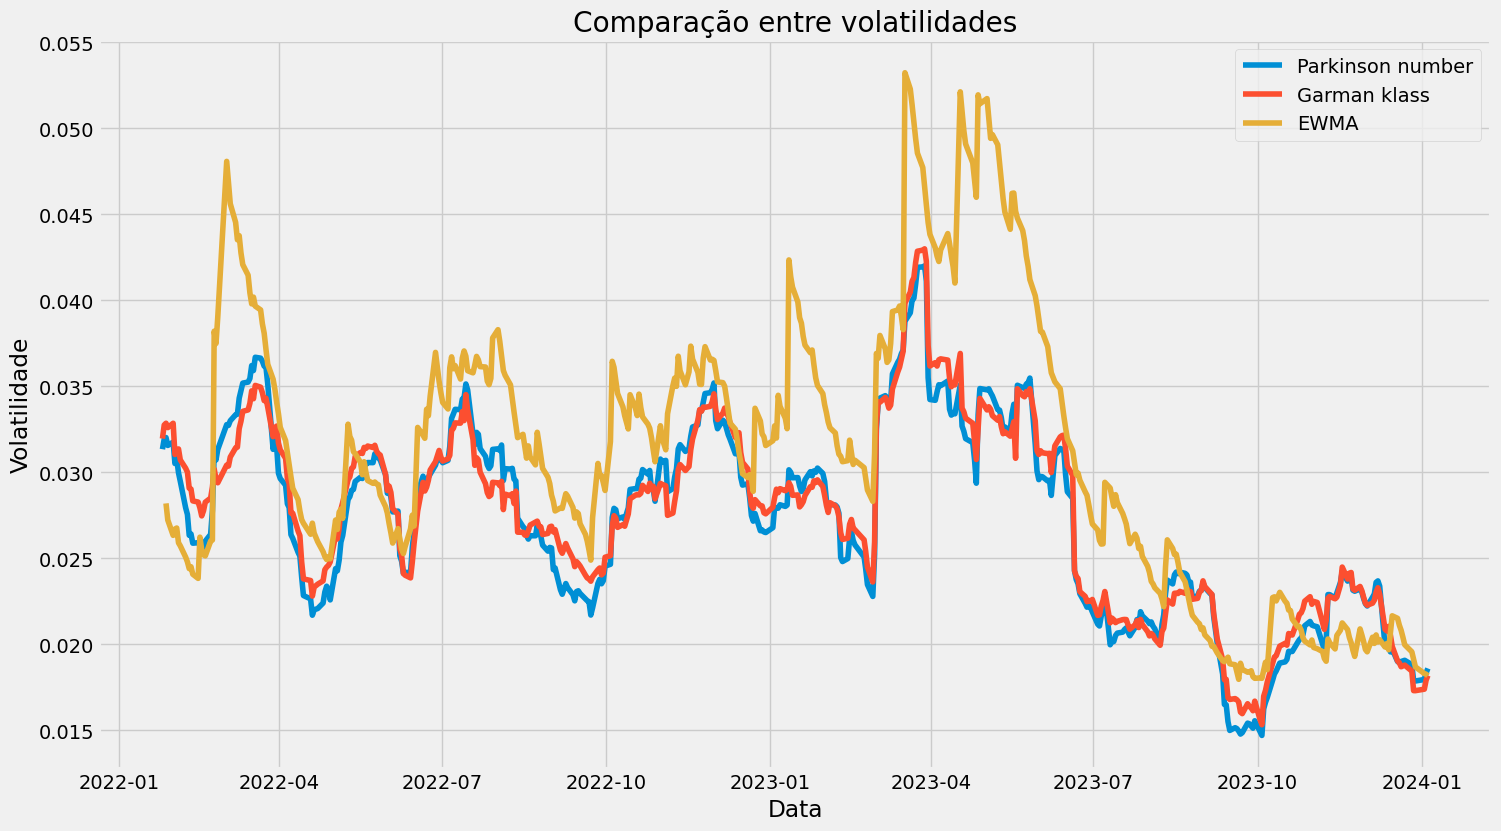

In [19]:
plt.figure(figsize=(16,9))

# Ativo que será plotada a comparação
asset = 0

plt.plot(pv_df.iloc[:,asset], label= "Parkinson number")
plt.plot(gk_df.iloc[:,asset], label="Garman klass")
plt.plot(vol_daily.iloc[21:,asset], label="EWMA")
# plt.plot(close_df.iloc[:,0].std().iloc[21:], label="std")

plt.title("Comparação entre volatilidades")
plt.xlabel("Data")
plt.ylabel("Volatilidade")

plt.legend()
plt.show()

Para efeito de comparação construímos o gráfico das 3 volatilidades em um preço de contrato futuro. Podemos perceber que, principalmente em momentos de maior estresse, os modelos Parkinson e Garman Klass têm uma resposta mais rápida e mais precisa. Um período que pode-se destacar é o ano de 2008, que os dois modelos acabaram captando mais informações intra diárias da crise da bolha hipotecária.

In [20]:
def response (x):
    
    return (x * np.exp((-x ** 2) / 4)) / 0.89

def HL (n):
    
    return np.log(0.5) / np.log(1 - 1/n)

def momentum_cta(returns, sk, lk):
    
    sets = len(sk)
    
    signals = []
    
    for k in range(sets):
        
        xk = returns.ewm(halflife = HL(sk[k])).mean() - returns.ewm(halflife = HL(lk[k])).mean()
        
        yk = xk / returns.rolling(63).std()
        
        zk = yk / returns.rolling(252).std()
        
        uk = response(zk)
        
        signals.append(uk)
        
    cta = pd.DataFrame(signals).mean()
        
    return cta

<Axes: xlabel='datetime'>

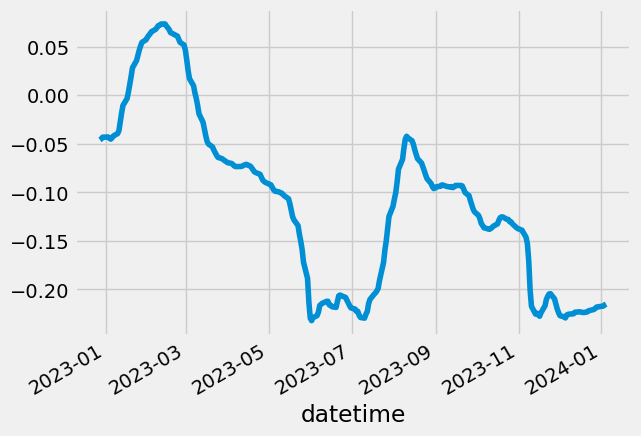

In [21]:
momentum_cta(close_df.iloc[:,0], np.array([16, 32, 64]), np.array([48, 96, 192])).plot()

<Axes: xlabel='datetime'>

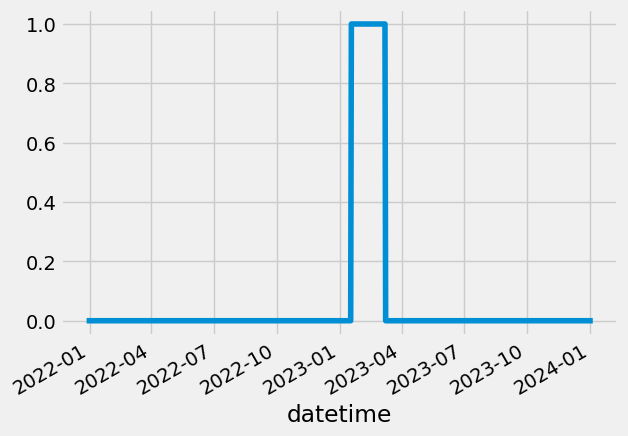

In [22]:
((momentum_cta(close_df.iloc[:900,0], np.array([16, 32, 64]), np.array([48, 96, 192])) > 0).astype(int)).plot()

## Estratégia

![Equação do TSMOM](images/tsmom_eq.jpeg)

Em resumo a equação final do TSMOM do Moskowitz pode ser dividida nos seguintes tópicos: 
- Posição
- Alocação
- Retorno do portfólio

#### Posição

Para determinar a posição de compra ou venda de um ativo, é necessário algum sinal de previsão, neste caso é utilizado o momentum (retorno) de 12 meses. Com o sinal em mãos classifica-se a posição a partir da direção do momentum.

#### Alocação

Quando se trata de alocação de portfólio no mundo quantitativo, existem diversas ferramentas, tais como: matrizes de covariâncias, autovalores, autovetores, PCA, autoencoders e entre outros. Mas para simplificar nosso modelo, iremos controlar as alocações para que elas estejam, em média, entorno de uma meta de risco. Definiremos o desvio padrão anual médio da carteira como meta, pois estamos dispostos a ter um risco médio de um contrato futuro, que no caso dos nossos dados é de 40%.
Para o risco estimado, podemos utilizar as volatilidades discutidas nos tópicos anteriores. Com os dois parâmetros necessários (risco estimado e risco médio), temos uma razão que é inversamente proporcional ao risco de um ativo, ou seja, ativos muito voláteis acabam tendo uma alocação menor, e o contrário ocorre para ativos com baixo risco, que têm uma maior parcela na carteira.
Vale ressaltar que ambos os casos tendem a se normalizar para o risco do portfólio (40%). Por exemplo: um ativo com 20% de volatilidade, o cálculo da alocação seria o seguinte: 40%/20% = 2, ou seja, esse ativo teria um alavancagem de 2 vezes, o que dobraria seu risco.

#### Retorno do portfólio

Por fim, temos o número que realmente importa, o rendimento total do investimento. Podemos calculá-lo no fim do período, com os retornos de cada ativo. Graças a simplificação de alocação, podemos calcular a média do retorno de todos ativos (St), esse será o retorno do portfólio, conforme a imagem acima.

In [23]:
# Importando algoritmos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor
from sklearn.ensemble     import RandomForestRegressor
from sklearn import svm

# Classification ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Funções de backtesting e visualização

In [24]:
def get_feature_target(parameters, stock, date):
    
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = parameters
    
    train = pd.DataFrame()

    train["Returns Monthly"] = returns_monthly.iloc[:,stock]
    train["EWMA"] = vol_monthly.iloc[:,stock]
    train["Parkinson"] = pv_monthly.iloc[:,stock]
    train["Garman-Klass"] = gk_monthly.iloc[:,stock]
    train["Monthly Volume"] = monthly_volume_df.iloc[:,stock]
    train["Momentum CTA"] = momentum_cta(close_df.iloc[:,stock], np.array([16, 32, 64]), np.array([48, 96, 192])).resample("BM").last().ffill()

    prices = close_df.iloc[:,stock]

    for lag in [3, 6, 9, 12]:
        train["Momentum " + str(lag)] = prices.pct_change(lag * 21)

    target = train["Returns Monthly"].shift(-1)
    
    features = train.dropna()
    target = target.dropna()
    
    return (features.iloc[:date], target.iloc[:date], features.iloc[date])

def ml_signal(model, parameters, date):
    """
    Função que constroí o vetor de posições (long ou short), utilizando machine learning
    """
    signal = []

    for stock in range(54):

        features, target, X_test = get_feature_target(parameters, stock, date)
            
        # **TRAIN DATA**
        # Features
        X = features

        # Target
        y = np.sign(target)

        # Fitting the model
        model.fit(X, y)
        
        pred = model.predict([X_test])
        signal.append(pred[0])
        
    return signal

def signal(parameters, date, passive, pre_trained_model=None, method="momentum"):
    """
    Função que constrói o sinal para diversos metodos, sendo o tradicional: momentum
    """
    
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = parameters
        
    num_assets = len(close_df.columns)
    positions = []
    
    if passive:
        positions = np.ones(num_assets)
    else:
    
        if method == "momentum":

            returns = close_df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            positions = np.where(returns.iloc[-1] > 0, 1, -1)

        elif method == "momentum_lagged":

            returns_12 = close_df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            returns_6 = close_df.pct_change(21 * 6).resample('BM').last().ffill()[:date]

            returns_3 = close_df.pct_change(21 * 3).resample('BM').last().ffill()[:date]

            momentum_mean = (returns_12.iloc[-1] + returns_6.iloc[-1] + returns_3.iloc[-1]) / 3

            positions = np.where(momentum_mean > 0, 1, -1)
            
        elif method == "svc":

            positions = ml_signal(SVC(), parameters, date-1)
            
        elif method == "mlpc":

            positions = ml_signal(MLPClassifier(solver='lbfgs', 
                          alpha=1e-3, 
                          activation='relu',
                          hidden_layer_sizes=(5, 3), 
                          random_state=1), parameters, date-1)
            
        elif method == "random_forest":
            positions = ml_signal(RandomForestClassifier(), parameters, date-1)
            
        elif method == "monkey":
        
            positions =  (np.random.randn(num_assets) < 0.5).astype(int)
            
        elif method == "momentum_cta":
            signals = []
            for asset in close_df.columns:
                cta = (momentum_cta(close_df[asset], np.array([16, 32, 64]), np.array([48, 96, 192]))).resample('BM').last().ffill()[:date][-1]
                signals.append(cta)
               
            positions = signals
    
    return positions
    
def tsmom (paramters, date, vol="ewma", method = 'momentum', risk=0.4, passive=False, momentum_window=12):
    """
    Simula a estrátegia de investimento em um período, retorna a rentabilidade no período simulado.
    """
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = paramters
    
    vol_monthly = []
    
    if vol == "ewma":
        vol_monthly = ewma_vol
    elif vol == "parkinson":
        vol_monthly = pv_monthly
    elif vol == "garman_klass":
        vol_monthly = gk_monthly
    else:
        raise NameError('Volatilidade invalida')
    
    positions = signal(parameters, date, passive, method)
    
    # Month consts
    Last_Month = date - 1
    Actual_Month = date
    
    weights = (risk / vol_monthly.iloc[Last_Month])
    
    normalized_weights = weights / len(weights)
    
    portfolio = positions * normalized_weights
    
    period_return = 1 + np.dot(portfolio, returns_monthly.iloc[Actual_Month])
    
    return period_return

In [25]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Barra de progresso
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def plot_backtesting(returns_model, returns_baseline, years, label_model, label_baseline, title):

    plt.figure(figsize=(16, 9))

    plt.plot(100*returns_model.cumprod(), label=label_model, color='blue')
    plt.plot(100*returns_baseline.cumprod(),
             label=label_baseline, color='red')

    plt.yscale('log')
    plt.legend()
    plt.title(title)
    plt.show()
    
    passive_return = float((returns_baseline.cumprod().iloc[-1] - 1)*100)
    tsmom_return = float((returns_model.cumprod().iloc[-1] - 1)*100)
    
    r = returns_model - 1 
    rp = returns_baseline - 1
    
    # Sharpe
    sharpe_r = np.sqrt(12) * r.mean()/r.std()
    sharpe_rp = np.sqrt(12) * rp.mean() / rp.std()
    
    # Beta
    beta_matrix = pd.concat([r, rp], axis =1)

    beta = beta_matrix.cov().iloc[0,1]/ rp.std()

    print('Passive ', label_baseline, ' return: ', round(passive_return,2), '%,',
         " Annualized: ", round((((100+passive_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')

    print('TSMOM ', label_model, ' return: ', round(tsmom_return,2), "%,",
         " Annualized: ", round((((100+tsmom_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')
    print("Sharpe ratio Model: ", sharpe_r[0] )
    print("Sharpe ratio Long Only: ", sharpe_rp[0])
    print("Beta: ", beta[0])
    
def backtesting(parameters, vol, start_date, years, method, risk=0.4, plot=True):
    """
    Função que realiza o backtesting do algoritmo
    """
    start_time = time.time()
    
    returns_model = []  
    returns_baseline = []
    sharpe = []
    
    end_date = 12 * (int(start_date/12) + years)


    for time_step in range(start_date, end_date):
        
        printProgressBar (iteration=time_step-start_date, total=end_date-start_date-1)
        
        returns_model.append(tsmom(parameters, time_step, vol, method, risk))

        returns_baseline.append(tsmom(parameters, time_step, vol, risk, passive=True))

    returns_model = pd.DataFrame(returns_model)
    returns_baseline = pd.DataFrame(returns_baseline)

    returns_model.index = returns_monthly.iloc[start_date:end_date].index
    returns_baseline.index = returns_monthly.iloc[start_date:end_date].index

    if plot:
        plot_backtesting(returns_model, returns_baseline, years, method, "Long only", "Cumulative returns")

    print("Tempo: %s segundos" % (time.time() - start_time))
        
    return [returns_model, returns_baseline]

# Backtesting

## Momentum com EWMA como estimador de risco
Implementação Clássica do paper do Moskowitz

In [26]:
parameters = (returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, vol_monthly, pv_monthly, gk_monthly )

NameError: name 'monthly_volume_df' is not defined

In [ ]:
r_cl, rp_cl = backtesting(parameters, vol="ewma", start_date = 12, years=19,risk=0.4, method="momentum", plot=True);

IndexError: single positional indexer is out-of-bounds

E aqui finalmente temos os resultados do TSMOM. Ao total, obtemos 382.36% na estratégia original e 563.65% na long only. Que anualizando os retornos temos respectivamente 8.63% e 10.47%. Apesar de, no longo prazo, o TSMOM não superar o seu índice (Long only), é importante ressaltar a performance entre os anos 2000 e 2009. Período no qual ocorreram duas importante crises: bolha da internet (“dot-com”) e bolha hipotecária.

## Momentum Com  Parkinson como estimador

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


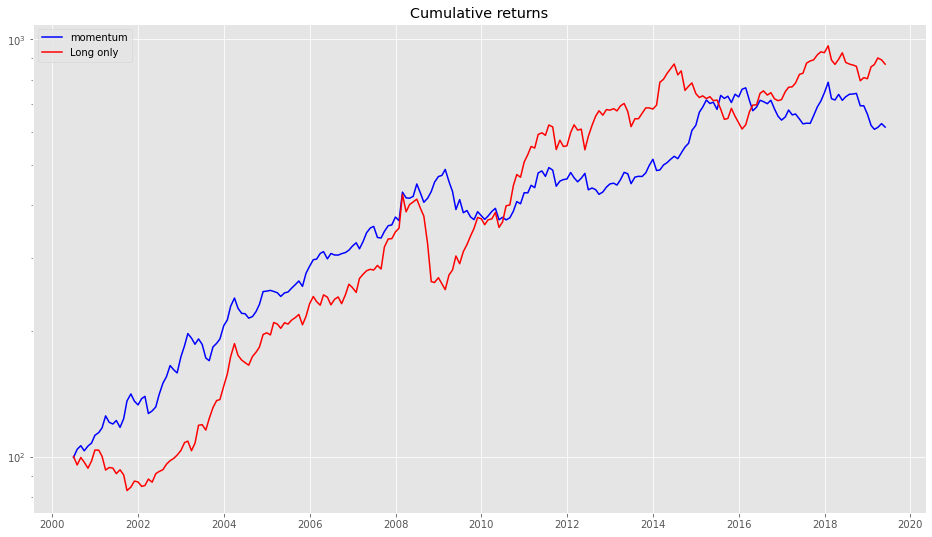

Passive Long only return: 771.56%, Annualized: 12.07%
TSMOM momentum return: 516.08%, Annualized: 10.04%
Sharpe ratio Model:  0.7714308185964853
Sharpe ratio Long Only:  0.7763354358909687
Beta:  0.00733776693636075
Tempo: 3.825995683670044 segundos


In [ ]:
r_cl_pk, rp_cl_pk = backtesting(parameters, vol="parkinson", start_date = 12, years=19, risk = 0.4, method="momentum", plot=True);

## Momentum com Garman Klass como estimador

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


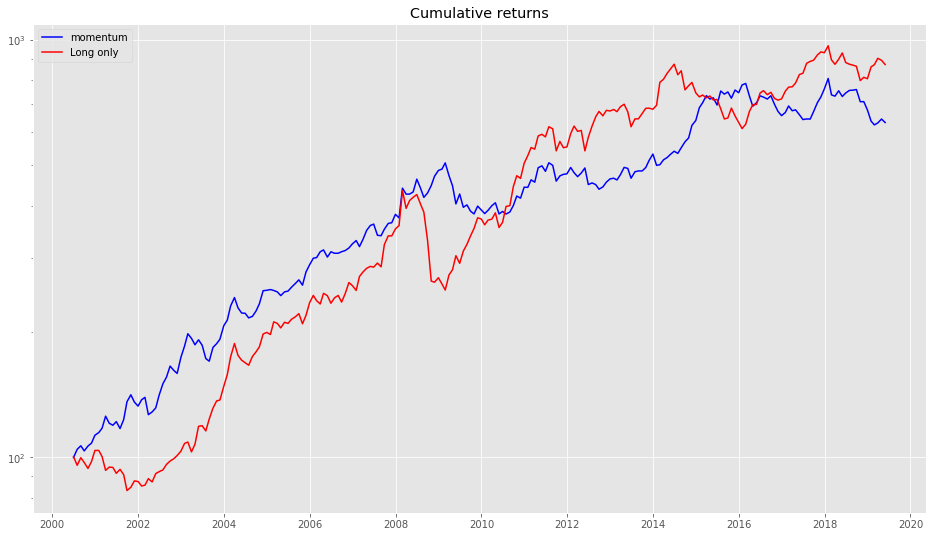

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum return: 533.62%, Annualized: 10.21%
Sharpe ratio Model:  0.7787711130879245
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.007209869559824512
Tempo: 2.9443111419677734 segundos


In [ ]:
r_cl_gk, rp_cl_gk = backtesting(parameters, vol="garman_klass", start_date= 12, years=19,risk=0.4, method="momentum", plot=True);

# Momemtums compostos, com diferentes estimadores de risco

## Momentum composto e EWMA

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


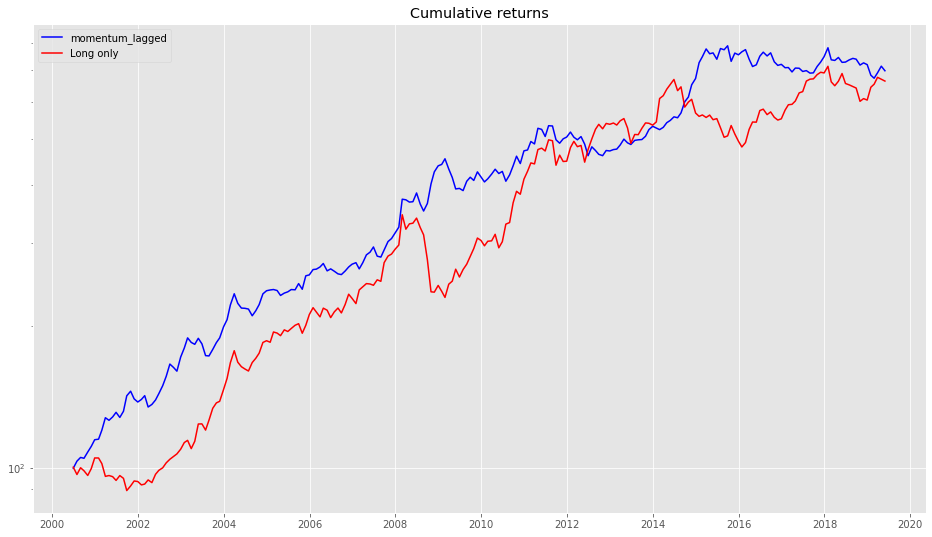

Passive Long only return: 563.65%, Annualized: 10.47%
TSMOM momentum_lagged return: 598.05%, Annualized: 10.77%
Sharpe ratio Model:  0.9748458179019419
Sharpe ratio Long Only:  0.7894018271213199
Beta:  0.005346797411486292
Tempo: 7.8609278202056885 segundos


In [ ]:
r_mom, rp_mom = backtesting(parameters, vol="ewma", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

## Momentum composto e Parkinson 

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


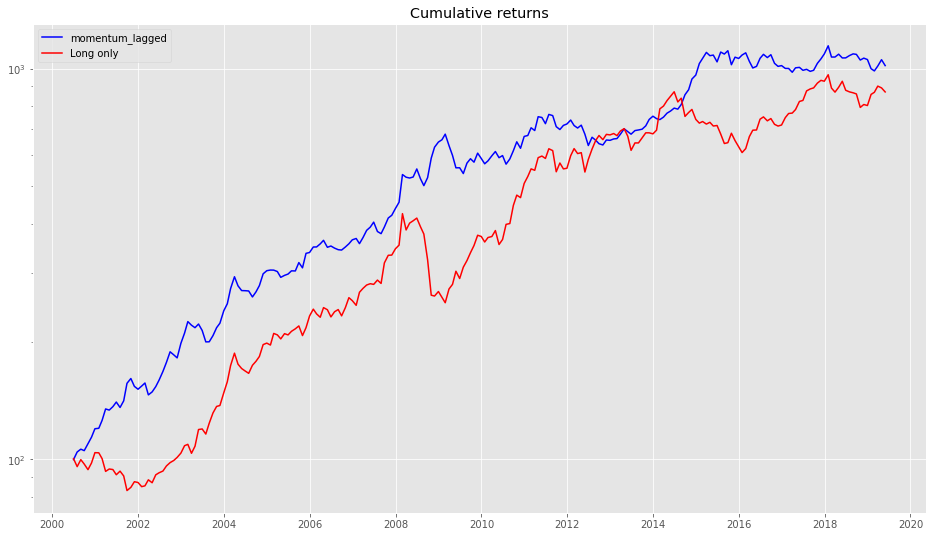

Passive Long only return: 771.56%, Annualized: 12.07%
TSMOM momentum_lagged return: 918.1%, Annualized: 12.99%
Sharpe ratio Model:  0.9951401528271197
Sharpe ratio Long Only:  0.7763354358909687
Beta:  0.0063684919137540034
Tempo: 7.327611684799194 segundos


In [ ]:
r_mom_pk, rp_mom_pk = backtesting(parameters, vol="parkinson", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

## Momentum composto e Garman Klass

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


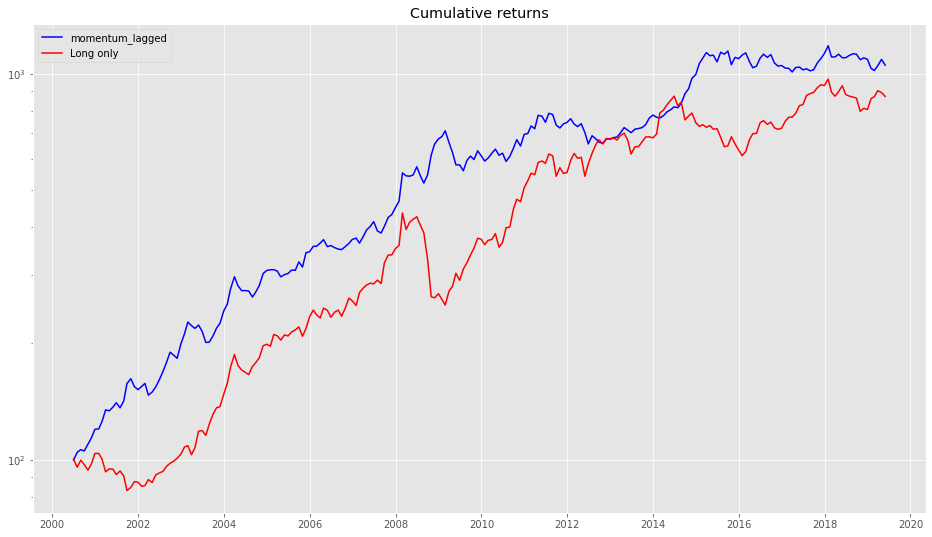

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum_lagged return: 951.62%, Annualized: 13.18%
Sharpe ratio Model:  1.002972466006768
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.0062369984878071745
Tempo: 7.569063901901245 segundos


In [ ]:
r_mom_gk, rp_mom_gk = backtesting(parameters, vol="garman_klass", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

Com o intuito de adicionar mais informações no modelo, utilizamos o estimador de risco Garman-Klass e construímos um momentum modificado. Que é basicamente a média de momentums com períodos diferentes, os escolhidos foram 3, 6 e 12 meses. Essas modificações fizeram nosso algoritmo performar melhor que o Long Only, tal feito pode ser justificado pela a adição de informações mais recentes ao modelo, fazendo-o reagir mais rapidamente a grandes variações de preço. Com essas modificações alcançamos o resultado de 951,62%! Que anualizado implica em 13,18%.

 |█████████████████████████████████████████-----------------------------------------------------------| 41.4%  |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


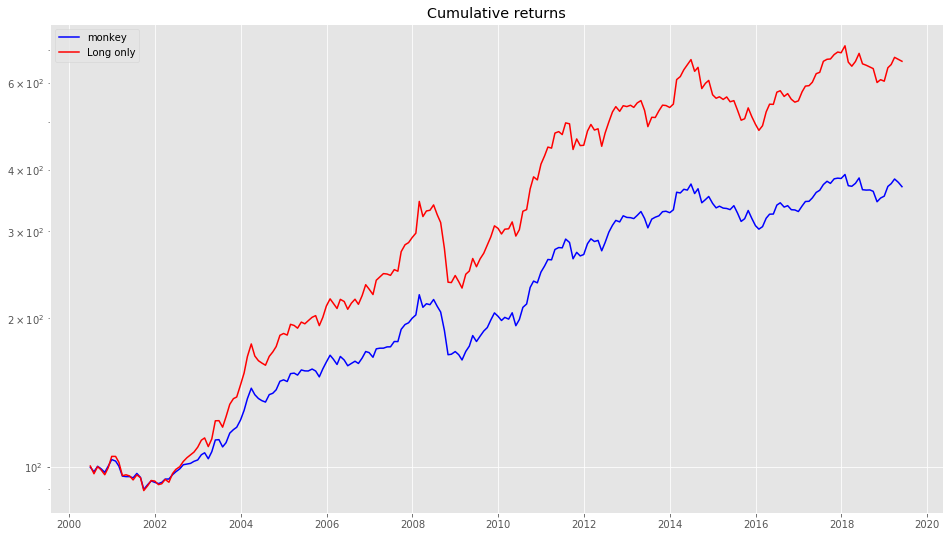

Passive Long only return: 563.65%, Annualized: 10.47%
TSMOM monkey return: 269.52%, Annualized: 7.12%
Sharpe ratio Model:  0.7430682271013413
Sharpe ratio Long Only:  0.7894018271213199
Beta:  0.027878638945478817
Tempo: 0.8345999717712402 segundos


In [ ]:
r_monkey, rp_monkey = backtesting(parameters, vol="ewma", start_date= 12, years=19, risk=0.4, method="monkey", plot=True);

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


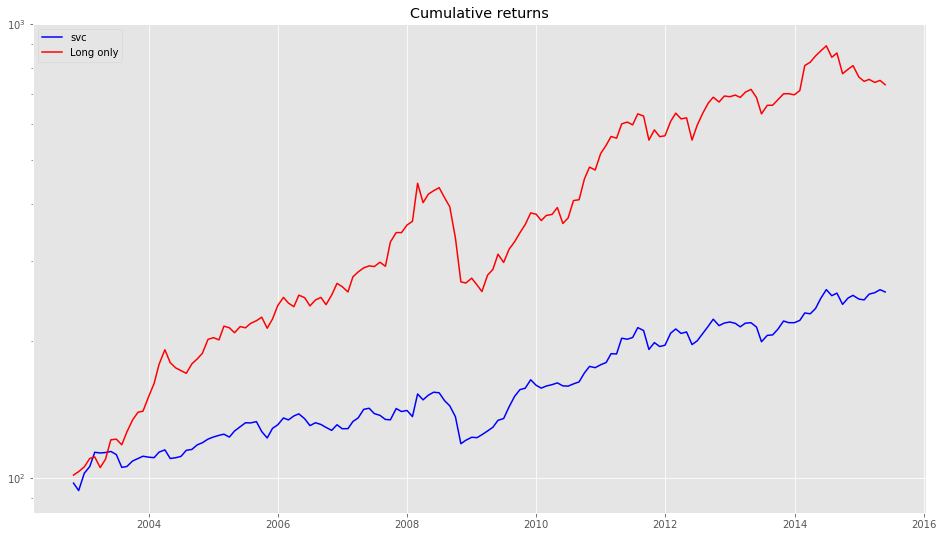

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM svc return: 156.37%, Annualized: 7.51%
Sharpe ratio Model:  0.7143692506196533
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.02371529447274548
Tempo: 1438.8184978961945 segundos


In [ ]:
r_svc, rp_svc = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.4, method="svc", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


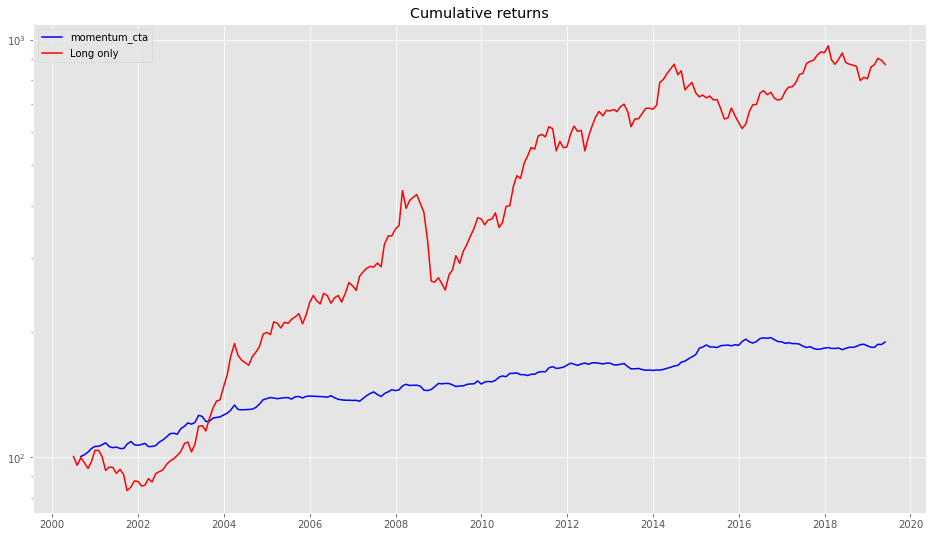

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum_cta return: 88.8%, Annualized: 3.4%
Sharpe ratio Model:  0.9724371646992064
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.0014515805484460627
Tempo: 2006.4288051128387 segundos


In [ ]:
r_cta, rp_cta = backtesting(parameters, vol="garman_klass", start_date = 12, years=19, risk=0.4, method="momentum_cta", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


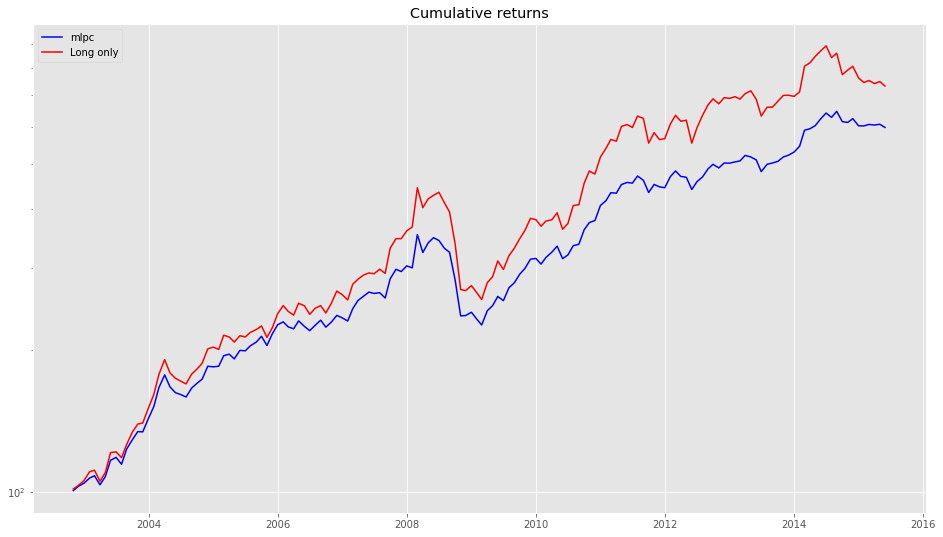

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM mlpc return: 498.36%, Annualized: 14.75%
Sharpe ratio Model:  1.077135991903228
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.039095490922791507
Tempo: 1445.099669933319 segundos


In [ ]:
r_mlpc, rp_mlpc = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.4, method="mlpc", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


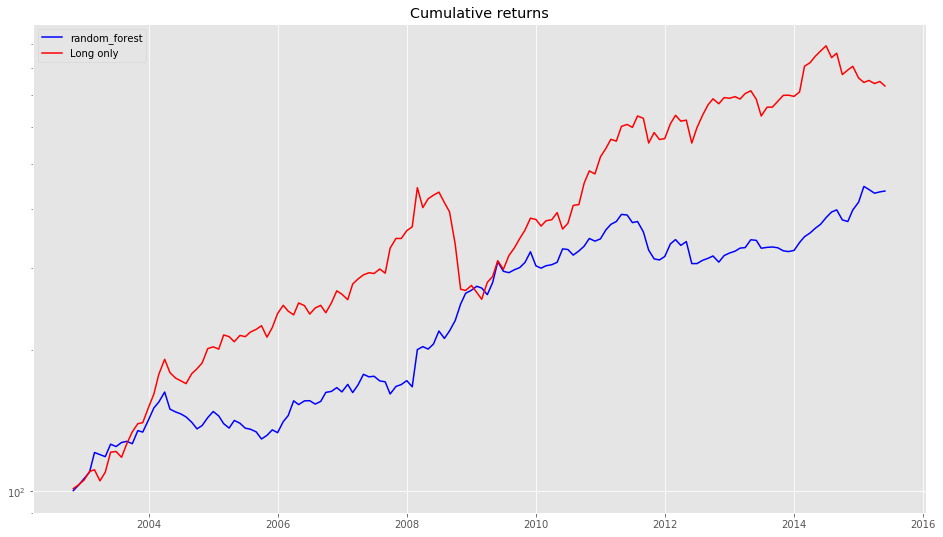

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM random_forest return: 337.5%, Annualized: 12.02%
Sharpe ratio Model:  0.9482004303039369
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.009541236606062943
Tempo: 2441.2534914016724 segundos


In [ ]:
r_rf, rp_rf = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.6, method="random_forest", plot=True);


## LSTM